## **Librerías**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from datetime import datetime, timedelta

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [5]:
import warnings
warnings.filterwarnings('ignore')

## **Datos**

### **Dataset de ventas**

**Enlace de los datos**: https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset

In [6]:
df = pd.read_csv('../../Data/online_retail.csv')

In [7]:
df.sample()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
339025,566577,23182,TOILET SIGN OCCUPIED OR VACANT,5,2011-09-13 13:29:00,2.5,NaN,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### **Limpieza y transformación de los datos**

In [9]:
# Eliminamos valores nulos
df.dropna(inplace=True)

In [10]:
# Ajustamos el formato de los datos
df['CustomerID'] = df['CustomerID'].apply(lambda x: int(x))
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: pd.to_datetime(x))

In [11]:
# Eliminamos valores que no tienen sentido
df = df.query('Quantity > 0')

In [12]:
# Creamos nuevos features
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

### **Dataset de clientes**

In [13]:
reference_date = df['InvoiceDate'].max() + timedelta(1)

In [14]:
df_customers = (
    df
    .groupby('CustomerID').agg({
        'InvoiceDate': [lambda x: (reference_date - x.max()).days],
        'InvoiceNo': ['count'],
        'Total_Price': ['sum']
    })
    .reset_index()
)

df_customers.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']
df_customers.sample()

,Customer_ID,Recency,Frequency,Monetary
2524,15780,184,29,475.28


In [17]:
df_customers.sample()

,Customer_ID,Recency,Frequency,Monetary
3940,17732,373,18,303.97


#### **Transformación de la data**

In [33]:
scaler = StandardScaler()

In [35]:
rfm_normalized = scaler.fit_transform(
    df_customers[['Recency', 'Frequency', 'Monetary']]
)

## **Modelo**

### **Determinar la cantidad de Clusters**

In [36]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, init='k-means++', n_init=10, random_state=13)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

In [38]:
import plotly.express as px

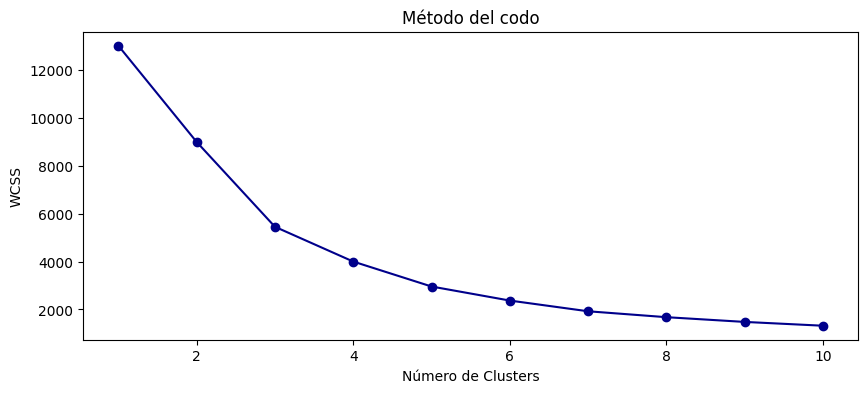

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(
    range(1, 11),
    wcss, 
    marker='o',
    color='darkblue'
)

plt.title('Método del codo')

plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

plt.show()

### **Aplicación del modelo**

In [84]:
kmean_model = KMeans(
    n_clusters=5,
    init='k-means++', 
    max_iter=300, 
    n_init=10, 
    random_state=13
)

In [85]:
clusters = kmean_model.fit_predict(rfm_normalized)

In [86]:
df_customers['Cluster'] = clusters

In [87]:
df_customers.columns

Index(['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'Cluster'], dtype='object')

In [88]:
df_customers.groupby('Cluster').agg({
    'Customer_ID': 'count',
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'], 
    'Monetary': ['mean', 'median']
})

Customer_ID     Recency         ... Frequency       Monetary            
              count        mean median  ...    median           mean      median
Cluster                                 ...                                     
0               238   16.075630    8.0  ...     413.5   12082.723529    6889.865
1              3036   44.255270   33.0  ...      50.0    1346.975156     813.295
2              1055  249.476777  245.0  ...      18.0     490.446645     309.540
3                 6    7.666667    5.0  ...     573.5  190863.461667  181511.645
4                 4    2.000000    1.5  ...    5394.0   70925.287500   53078.180

[5 rows x 7 columns]

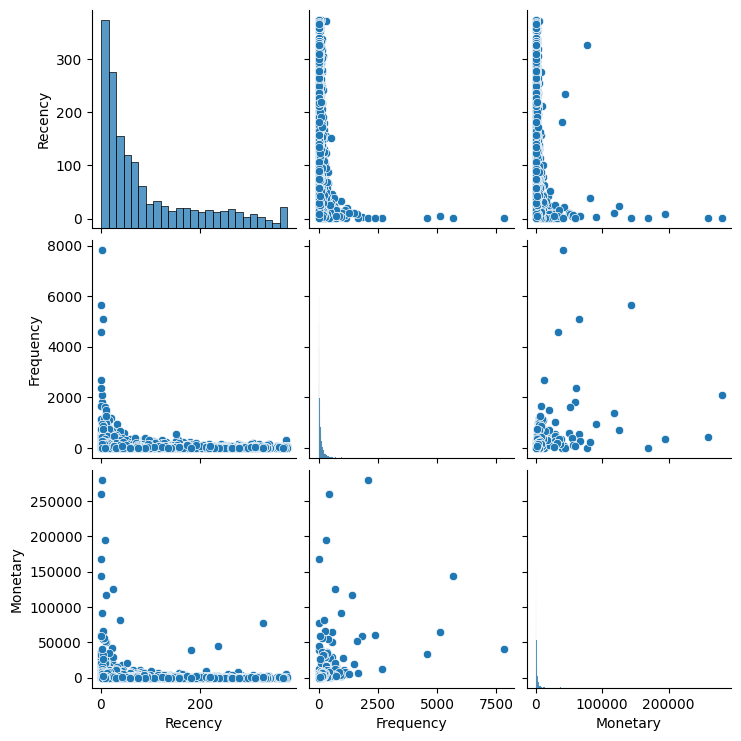

In [98]:
sns.pairplot(df_customers.drop(['Customer_ID', 'Cluster'], axis=1))

plt.show()

In [95]:
px.scatter(
    df_customers,
    x='Recency',
    y='Frequency',
    color='Cluster',
    opacity=0.7
)